# Classification

A notebook reproducing some classification examples from Elements of Statistical Learning.

In [1]:
import numpy as np
import scipy.stats as sps
import scipy.linalg as spl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
from mlalgos.supervised_learning.linear_regression import LinearRegression
from mlalgos.supervised_learning.knn import kNN
from mlalgos.supervised_learning.lda import LDA

# Generate some data

In [3]:
class DataGenerator():
    def __init__(self):
        # The distributions to generate fake data from following Chapter 2 of ESL
        self.means0 = sps.multivariate_normal(mean=[1,0], cov=np.eye(2)).rvs(10)
        self.means1 = sps.multivariate_normal(mean=[0,1], cov=np.eye(2)).rvs(10)
        self.gaussians0 = [sps.multivariate_normal(mean=m, cov=np.eye(2)/5) for m in self.means0]
        self.gaussians1 = [sps.multivariate_normal(mean=m, cov=np.eye(2)/5) for m in self.means1]

    def generate0(self, N):
        """
        Generates N data points for class 0.
        """
        X0 = []
        for i in range(N):
            idx = np.random.randint(10)
            X0.append(self.gaussians0[idx].rvs())
        return np.array(X0)

    def generate1(self, N):
        """
        Generates N data points for class 1.
        """
        X1 = []
        for i in range(N):
            idx = np.random.randint(10)
            X1.append(self.gaussians1[idx].rvs())
        return np.array(X1)
    
    def generate(self, N):
        """
        Generate data for both classes.

        Args:
            N   (int): Number of data points in each class

        Returns:
            (np.array, np.array): The features and the classes
        """
        X0 = self.generate0(N)
        X1 = self.generate1(N)
        X = np.append(X0, X1, axis=0)
        Y = np.append(np.zeros(N), np.ones(N))
        return X, Y

generator = DataGenerator()
X, Y = generator.generate(200)

# Define some plotting functions
(Move to package later if reused?)

In [4]:
# Some colours
GRAY1, GRAY4, PURPLE = '#231F20', '#646369', '#A020F0'
BLUE, ORANGE, BLUE1 = '#57B5E8', '#E69E00', '#174A7E'

In [5]:
def plot_train_data(title):
    fig, ax = plt.subplots(figsize=(2.8, 2.8), dpi=110)
    #ax.set_aspect(1.3)
    ax.scatter(X.T[0], X.T[1], s=18, facecolors='none',
               edgecolors=np.array([BLUE, ORANGE])[Y.astype(int)])
    ax.tick_params(
        bottom=False, left=False, labelleft=False, labelbottom=False)
    ax.set_xlim(-3, 4.)
    ax.set_ylim(-3., 4)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.text(-3, 4.2, title, color=GRAY4, fontsize=9)
    return fig, ax

In [6]:
def fill_prediction_grid(n1, n2, predict):
    x1, x2 = np.linspace(-3., 4., n1), np.linspace(-3., 4., n2)
    X = np.array([np.tile(x1, n2), np.repeat(x2, n1)])
    y = predict(X.T)
    return X, y>0.5

def fill_prediction_meshgrid(predict):
    n1, n2 = 1000, 1000
    X, y = fill_prediction_grid(n1, n2, predict)
    return X[0].reshape(n1, n2), X[1].reshape(n1, n2), y.reshape(n1, n2)

def plot_model(predict, title):
    fig, ax = plot_train_data(title)
    # plot background dots
    X, y = fill_prediction_grid(69, 99, predict)
    ax.scatter(X.T[:, 0], X.T[:, 1], marker='.', lw=0, s=2,
               c=np.array([BLUE, ORANGE])[y.astype(int)])
    # plot the decision boundary
    X0, X1, Y = fill_prediction_meshgrid(predict)
    ax.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.7])
    return fig, ax

# Linear Classifier

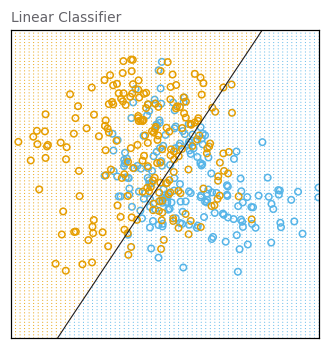

In [12]:
linear_classifier = LinearRegression()
linear_classifier.fit(X, Y)
linear_predict = linear_classifier.predict

fig_linear, _ = plot_model(linear_predict, 'Linear Classifier')

# $k$ Nearest Neighbours

In [55]:
knn = kNN(15)
knn.fit(X, Y)
knn_predict = knn.predict

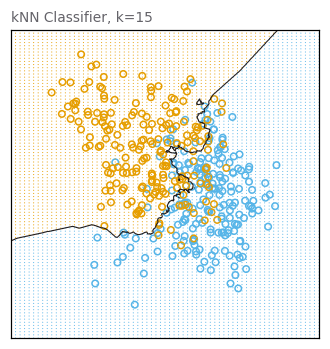

In [56]:
fig_knn15, _ = plot_model(knn_predict, 'kNN Classifier, k=15')

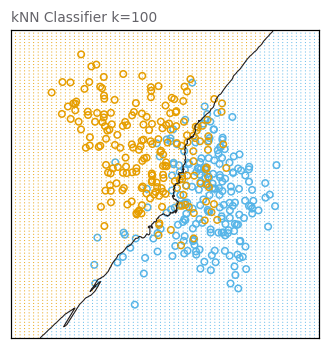

In [57]:
knn100 = kNN(k=100)
knn100.fit(X, Y)
_, _ = plot_model(knn100.predict, 'kNN Classifier k=100')

# Optimal Bayes

Since we know the generating distributions, we can use an optimal Bayes classifier and compare the results

In [58]:
class OptimalBayes():
    def __init__(self, datagenerator):
        self.gaussians0 = datagenerator.gaussians0
        self.gaussians1 = datagenerator.gaussians1
    def predict(self, x):
        n = len(self.gaussians0)
        p0 = (1./n) * np.sum(np.array([g.pdf(x) for g  in self.gaussians0]),axis=0)
        p1 = (1./n) * np.sum(np.array([g.pdf(x) for g  in self.gaussians1]),axis=0)
        return (p1 > p0).astype(int)

optimal_bayes = OptimalBayes(generator)

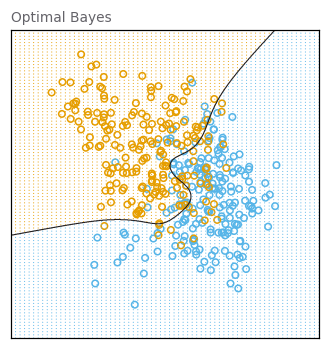

In [59]:
fig_bayes, _ = plot_model(optimal_bayes.predict, 'Optimal Bayes')

# Compare kNN performance to optimal Bayes

In [60]:
# Generate test data
Xtest, Ytest = generator.generate(5000)

def err(y, y_true):
    return np.sum(y != y_true)/np.shape(y_true)[0]

In [61]:
lin_train_err = err((linear_predict(X)>0.5).astype(int), Y)
lin_test_err = err((linear_predict(Xtest)>0.5).astype(int), Ytest)

In [62]:
opt_bayes_err = err(optimal_bayes.predict(Xtest), Ytest)

In [63]:
ks = [1, 3, 5, 7, 11, 15, 20, 30, 45, 60, 80, 110, 150, 199]
knn_train_err = []
knn_test_err = []
for k in ks:
    knn_model = kNN(k=k)
    knn_model.fit(X, Y)
    knn_train_err.append(err(knn_model.predict(X), Y))
    knn_test_err.append(err(knn_model.predict(Xtest), Ytest))

In [64]:
dof = 200/np.array(ks)

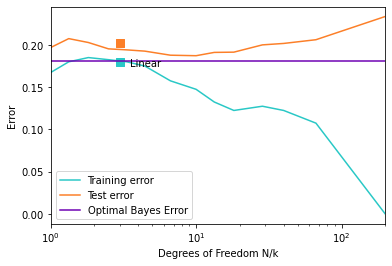

In [65]:
fig, ax = plt.subplots()
ax.plot(dof[::-1], knn_train_err[::-1], c='#29C8C6', label='Training error')
ax.plot(dof[::-1], knn_test_err[::-1], c='#FC7F28', label='Test error')
ax.scatter([3], [lin_train_err], c='#29C8C6', s=50, marker='s')
ax.scatter([3], [lin_test_err], c='#FC7F28', s=50, marker='s')
ax.text(3.5, lin_train_err-0.005, 'Linear')
ax.axhline(opt_bayes_err, c='#6D00B2', label='Optimal Bayes Error')
ax.set_xscale('log')
ax.set_xlabel('Degrees of Freedom N/k')
ax.set_ylabel('Error')
ax.set_xbound([1,200])
ax.legend()

# Linear Discriminant Analysis

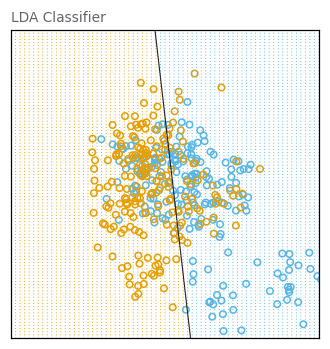

In [7]:
lda_classifier = LDA()
lda_classifier.fit(X, Y)
lda_predict = lda_classifier.predict

fig_lda, _ = plot_model(lda_predict, 'LDA Classifier')

In [9]:
# Generate some data with three classes

class DataGenerator3Classes():
    def __init__(self):
        self.mean0 = [-1, -1]
        self.mean1 = [1, -1]
        self.mean2 = [0, 1]
        self.cov = np.array([[1, 0.5], [0.5, 1]])
        self.gaussian0 = sps.multivariate_normal(mean=self.mean0, cov=self.cov)
        self.gaussian1 = sps.multivariate_normal(mean=self.mean1, cov=self.cov)
        self.gaussian2 = sps.multivariate_normal(mean=self.mean2, cov=self.cov)

    def generate_class(self, N, dist):
        """
        Generates N data points for a class.
        """
        X = []
        for i in range(N):
            X.append(dist.rvs())
        return np.array(X)

    def generate(self, N):
        """
        Generate data for both classes.

        Args:
            N   (int): Number of data points in each class

        Returns:
            (np.array, np.array): The features and the classes
        """
        X0 = self.generate_class(N, self.gaussian0)
        X1 = self.generate_class(N, self.gaussian1)
        X2 = self.generate_class(N, self.gaussian2)
        X = np.append(X0, np.append(X1, X2, axis=0), axis=0)
        Y = np.append(np.zeros(N), np.append(np.ones(N), 2*np.ones(N)))
        return X, Y

generator3 = DataGenerator3Classes()
X, Y = generator3.generate(200)

In [ ]:
# Modify the plotting functions
